# Reinforcement Learning
# TP 2 - The Exploration-Exploitation Dilemma

Student: Pierre-Louis Guhur

# 1. Stochastic Multi-Armed Bandits on Simulated Data

## 1.1 Bernoulli bandit models

**A multi-armed bandit model is a collection of arms:
                                ```MAB = {Arm1, Arm2, ...,ArmK}```
Start by defining your own Bernoulli bandit model with K arms of means $p_1, . . . , p_K$**

In [1]:
from arms import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline
from numpy import sqrt, log 
from IPython.display import display, clear_output
import time


K = 4
means = np.random.random(K)
MAB = [ArmBernoulli(m) for m in means]
assert(MAB[0].mean == means[0])

***1.* Write two functions
              `[rew,draws]=UCB1(T,MAB,...)` and `[rew,draws]=TS(T,MAB,...)`
simulating a bandit game of length $T$ with the UCB1 and Thompson Sampling strategy on the bandit model MAB: `rew` and `draws` are the sequence of the $T$ rewards obtained and of the $T$ the arms drawn.**

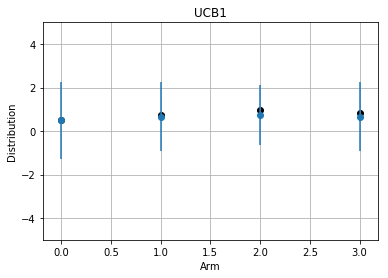

In [16]:

def _update_empirical_mean(mu, value, N):
    ''' Online update of the emperical mean '''
    return N/(N+1) * mu + 1/(N+1) * value


def _update_ucb(B, mu, N, t, rho=sqrt(3)):
    K = len(B)
    for i in range(K):
        B[i] = mu[i] + rho*sqrt(log(t)/N[i])
        

def plot_UCB1(B, mu, gt=None, sleep=0.1, title="UCB1"):
    K = len(mu)
    plt.cla()
    ax = plt.gca()
    plt.errorbar(x=range(K), y=mu, yerr=(B-mu), fmt='o')
    plt.grid()
    plt.ylim(-5, 5)
    if gt is not None:
        plt.scatter(range(0, K), gt, color="k", label="ground truth")
    plt.draw()
    plt.xlabel("Arm")
    plt.ylabel("Distribution")
    plt.title(title)
#     time.sleep(sleep)
    display(plt.gcf(), display_id=True)
    clear_output(wait=True)
    
    
def UCB1(T, MAB, rho=sqrt(3), vis="all"):
    """The UCB1 algorithm starts with an initialization phase that draws each arm once, and for t ≥ K, chooses at time t + 1 arm
    $$A_{t+1} = argmax_{a\in{1,...,K }} = \hat{\mu}_a(t) + \rho_t \sqrt{\frac{\log t}{2N_a(t)}}$$
    """
    K = len(MAB) # number of arms
    mu = np.zeros(K) # empirical mean
    N = np.zeros(K) # number of times an arm was pulled
    B = np.zeros(K) # upper-confidence bound
    gt = [m.mean for m in MAB] # ground-truth
    draws = np.zeros(T+1)
    rew = np.zeros(T+1)
    
    # initialisation
    for i in range(K):
        s = MAB[i].sample()
        mu[i] = _update_empirical_mean(0, s, 0)
        B[i] = mu[i] + 0
        N[i] += 1
        draws[i] = i
        rew[i] = s
    
    # steps
    try:
        for t in range(K, T+1):
            _update_ucb(B, mu, N, t, rho=rho)
            a = np.argmax(B)
            s = MAB[a].sample()
            mu[a] = _update_empirical_mean(mu[a], s, N[a])
            N[a] += 1
            draws[t] = a
            rew[t] = s

            if vis == "all":
                plot_UCB1(B, mu, gt=gt, sleep=1e-3)
    except KeyboardInterrupt:
        pass
    
    return rew, draws, mu


rew, draws, mu = UCB1(50, MAB, vis='all')

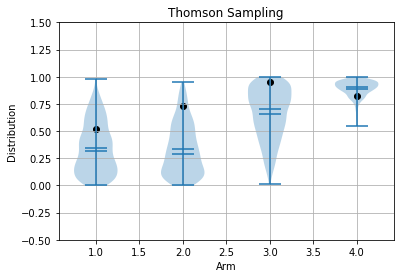

In [10]:
def _update_posterior(p, a, b):
    K = len(p)
    for i in range(K):
        p[i] = np.random.beta(a[i], b[i])
        
def plot_TS(a, b, gt=None, size=1000, sleep=1e-2):
    K = len(a)
    plt.cla()
    ax = plt.gca()
    all_data = [np.random.beta(a[i], b[i], size=size) for i in range(K)]
    plt.violinplot(all_data, showmeans=True, showmedians=True)
    if gt is not None:
        plt.scatter(range(1, K+1), gt, color="k", label="ground truth")
    plt.grid()
    plt.ylim(-0.5, 1.5)
    plt.xlabel("Arm")
    plt.ylabel("Distribution")
    plt.draw()
    plt.title("Thomson Sampling")
    time.sleep(sleep)
    display(plt.gcf(), display_id=True)
    clear_output(wait=True)
    
    
def TS(T, MAB, rho=sqrt(3), vis="all"):
    """Thomson sampling algorithm for Bernoulli distribution
    """
    K = len(MAB) # number of arms
    p = np.random.random(K) # prior distribution
    a = np.ones(K) # beta - a
    b = np.ones(K) # beta - b
    gt = [m.mean for m in MAB] # ground-truth
    draws = np.zeros(T+1)
    rew = np.zeros(T+1)
    
    # steps
    try:
        for t in range(1, T+1):
            _update_posterior(p, a, b)
            A = np.argmax(p)
            s = MAB[A].sample()
            a[A] += s
            b[A] += 1-s
            draws[t] = A
            rew[t] = s

            if vis == "all":
                plot_TS(a, b, gt=gt, sleep=1e-3)
    except KeyboardInterrupt:
        pass
    
    return rew, draws, p

rew, draws, p_opt = TS(200, MAB)

***2.* Based on many simulations, estimate the expected regret of UCB1 and Thompson Sampling and display regret curves.
You may also add the naive strategy that selects the empirical best arm at each round.**

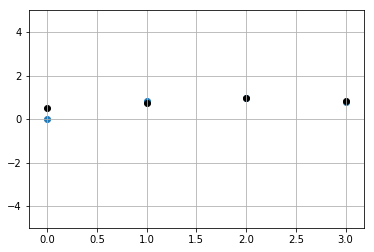

In [25]:
def plot_naive(mu, gt=None, sleep=0.1):
    K = len(mu)
    plt.cla()
    ax = plt.gca()
    plt.grid()
    plt.ylim(-5, 5)
    plt.scatter(range(K), mu, label="estimate $\mu$")
    if gt is not None:
        plt.scatter(range(K), gt, color="k", label="ground truth")
    plt.draw()
    plt.xlabel("Arm")
    plt.ylabel("Distribution")
    plt.title("Naive")
    time.sleep(sleep)
    display(plt.gcf(), display_id=True)
    clear_output(wait=True)
    
    
def naive(T, MAB, vis="all"):
    """Naive implementation that selects only the best arm
    """
    K = len(MAB) # number of arms
    mu = np.zeros(K) # empirical mean
    N = np.zeros(K) # number of times an arm was pulled
    B = np.zeros(K) # upper-confidence bound
    gt = [m.mean for m in MAB] # ground-truth
    draws = np.zeros(T+1)
    rew = np.zeros(T+1)
    
    # initialisation
    for i in range(K):
        s = MAB[i].sample()
        mu[i] = _update_empirical_mean(0, s, 0)
        B[i] = mu[i] + 0
        N[i] += 1
        draws[i] = i
        rew[i] = s
    
    # steps
    try:
        for t in range(K, T+1):
            a = np.argmax(mu)
            s = MAB[a].sample()
            mu[a] = _update_empirical_mean(mu[a], s, N[a])
            N[a] += 1
            draws[t] = a
            rew[t] = s

            if vis == "all":
                plot_naive(mu, gt=gt, sleep=1e-3)
    except KeyboardInterrupt:
        pass
    
    return rew, draws, mu

rew, draws, p_opt = naive(200, MAB)

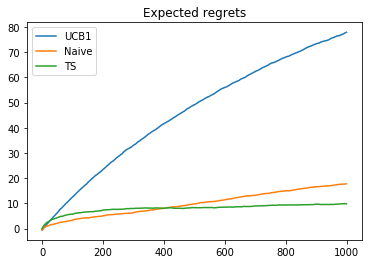

In [28]:
def expected_regret(mab, simulator, T=200, n_iter=100):
    cum_rew = np.zeros((n_iter, T+1))
    gt = [m.mean for m in mab]
    opt = np.max(gt)
    
    for i in range(n_iter):
        rew, draws, p = simulator(T, mab, vis="never")
        cum_rew[i, :] = np.cumsum(rew)
    
    exp_regrets = np.zeros(T)
    for t in range(T):
        exp_regrets[t] = t * opt - np.mean(cum_rew[:, t])
        
    return exp_regrets

    
T = 1000
regrets_ucb1 = expected_regret(MAB, UCB1, T=T)
regrets_naive = expected_regret(MAB, naive, T=T)
regrets_ts = expected_regret(MAB, TS, T=T)

plt.figure()
plt.plot(range(T), regrets_ucb1, label="UCB1")
plt.plot(range(T), regrets_naive, label="Naive")
plt.plot(range(T), regrets_ts, label="TS")
plt.title("Expected regrets")
plt.legend()
plt.show()

***3.* In a Bernoulli bandit model, Lai and Robbins lower bound [Lai and Robbins, 1985] tells that:
$$\lim \inf_{T\rightarrow \infty} \frac{R_T}{\log T} \geq \sum_{a:p_a \lt p^*} \frac{p^∗−p_a}{kl(p_a, p^*)}  :=C(p)$$
  with $kl(x, y) = KL(B(x), B(y)) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$.
$C(p)$ may be called the complexity of the problem.
Add the “oracle” regret curve $t \mapsto C(p) \log(t)$ on your graph.**

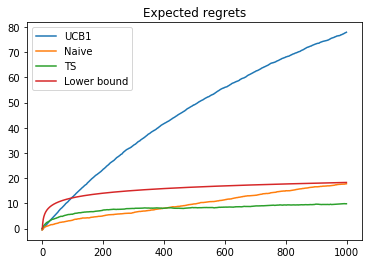

In [32]:
def Kullback_Leibler_2(x, y):
    return x*log(x/y) + (1-x) * log((1-x)/(1-y))

def oracle(mab):
    gt = [m.mean for m in mab]
    star = np.argmax(gt)
    p_star = gt[star]
    pa = [m for i, m in enumerate(gt) if i != star]
    C = np.sum([(p_star - p)/Kullback_Leibler_2(p, p_star) for p in pa])
    return C
    
regret_curve = oracle(MAB) * np.log(range(1, T))

plt.figure()
plt.plot(range(T), regrets_ucb1, label="UCB1")
plt.plot(range(T), regrets_naive, label="Naive")
plt.plot(range(T), regrets_ts, label="TS")
plt.plot(range(1, T), regret_curve, label="Lower bound")
plt.title("Expected regrets")
plt.legend()
plt.show()

***Q1:* For two different Bernoulli bandit problems (that you specify), with different complexity, compare the regret of Thompson Sampling with that of UCB1. Add Lai and Robbins’ lower bound on your plots.**

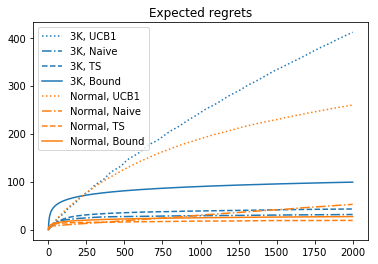

In [33]:
K = 10
T = 2000
means = np.random.random(3*K)
means_n = np.random.random(K)
problems = ["3K", "Normal"]
MABs = {problems[0]: [ArmBernoulli(m) for m in means],
        problems[1]: [ArmBernoulli(m) for m in means_n] }

plt.figure()

for pb in problems:
    regrets_ucb1 = expected_regret(MABs[pb], UCB1, T=T)
    regrets_ts = expected_regret(MABs[pb], TS, T=T)
    regrets_naive = expected_regret(MABs[pb], naive, T=T)
    regret_curve = oracle(MABs[pb]) * np.log(range(1, T))
    p = plt.plot(range(T), regrets_ucb1, label=f"{pb}, UCB1", linestyle=":")
    color = p[0].get_color()
    plt.plot(range(T), regrets_naive, label=f"{pb}, Naive", color=color, linestyle="-.")
    plt.plot(range(T), regrets_ts, label=f"{pb}, TS", color=color, linestyle="--")
    plt.plot(range(1, T), regret_curve, label=f"{pb}, Bound", color=color, linestyle="-")

plt.title("Expected regrets")
plt.legend()
plt.show()



We compare two MAB problems: in "3K", the number of arms is 3 times longer than in "normal". In "normal", the means are drawen from a normal distribution.

Quite interestingly, Lai and Robbins' lower bound is strongly reduced with the normal distribution. I think that one explanation is that the normal distribution maximises the entropy, thus the KL divergence (resp. the lower bound) is higher (resp. lower) than the uniform distribution.

Another explanation is that the normal distribution pushes more values close to zero. Hence, it is easier to improve to push the arms providing the best gains.

## 1.2 Non-parametric bandits (bounded rewards)
The UCB1 algorithm can be used in any bandit model such that each arm is bounded on [0,1], without modification.

**1. Using the other classes of arms, build a MAB with arms that are not only Bernoulli.
Why non-parametric? because we consider a MAB with different classes of arms (which can even be non parametric).**

1420.0
1327.531740132093
893.5898835623499
1126.5555555555593


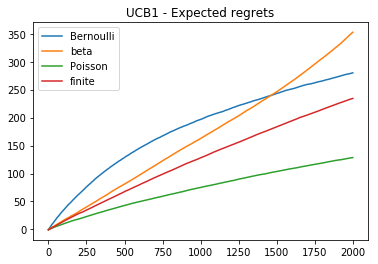

In [128]:
from sklearn.preprocessing import normalize

T = 100
MAB_np = {}
law = ["Bernoulli", "beta", "Poisson", "finite"]

means = np.random.random(K)
MAB_np[law[0]] = [ArmBernoulli(m) for m in means]

ab = np.random.random((K,2))
MAB_np[law[1]] = [ArmBeta(p[0], p[1]) for p in ab]
                      
lambdas = np.random.random(K)
MAB_np[law[2]] = [ArmBeta(l, 1) for l in lambdas]

support = np.linspace(0, 1, 10)
proba = np.random.random((K, len(support)))
normalize(proba, norm="l1", axis=1, copy=False)
MAB_np[law[3]] = [ArmFinite(support, proba[k]) for k in range(K)]
                         
                         
plt.figure()
for name in law:
    m = MAB_np[name]
    regrets_ucb1 = expected_regret(m, UCB1, T=T)
    p = plt.plot(range(T), regrets_ucb1, label=f"{name}")

plt.title("UCB1 - Expected regrets")
plt.legend()
plt.show()

**2. Propose an adaptation of Thompson Sampling to handle non-binary rewards and implement it together with UCB1 on your bandit model (see e.g., [Agrawal and Goyal, 2012]).**

In [2]:
def TS2(T, MAB, rho=sqrt(3), vis="all"):
    """
    Thomson sampling handling non-binary rewards [Agrawal and Goyal, 2012]
    """
    K = len(MAB) # number of arms
    p = np.random.random(K) # prior distribution
    a = np.ones(K) # beta - a
    b = np.ones(K) # beta - b
    gt = [m.mean for m in MAB] # ground-truth
    draws = np.zeros(T+1)
    rew = np.zeros(T+1)
    
    # steps
    for t in range(1, T+1):
        _update_posterior(p, a, b)
        A = np.argmax(p)
        s = MAB[A].sample()
        s_ber = np.random.random() < s
        a[A] += s_ber
        b[A] += 1-s_ber
        draws[t] = A
        rew[t] = s
        
        if vis == "all":
            plot_TS(a, b, gt=gt, sleep=1e-3)
        
    return rew, draws, p

T = 100
regrets_ucb1 = expected_regret(MAB, UCB1, T=T)
regrets_ts = expected_regret(MAB, TS2, T=T)

plt.figure()
for name in law:
    m = MAB_np[name]
    regrets_ucb1 = expected_regret(m, UCB1, T=T)
    p = plt.plot(range(T), regrets_ucb1, label=f"{name}, UCB1", linestyle="--")
    color = p[0].get_color()
    
    regrets_ts2 = expected_regret(m, TS2, T=T)
    plt.plot(range(T), regrets_ts2, label=f"{name}, TS2", linestyle="-.", color=color)

plt.title("Expected regrets")
plt.legend()
plt.show()

NameError: name 'expected_regret' is not defined

In [ ]:
import numpy as np
from numpy.linalg import inv
from numpy import sqrt
from linearmab_models import ToyLinearModel, ColdStartMovieLensModel
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm


def lin_ucb(T, model, alpha=2.8, lambda_=1e-3):
    """ Compute a linear UCB algorithm """
        
    def _find_best_action(features, Z, theta, alpha, l):
        n_a, d = features.shape
        bound = np.zeros(n_a)
        for a in range(n_a):
            phi_a = features[a]
            IRLS = inv(Z.T.dot(Z) + l * np.eye(d))
            beta = alpha*np.sqrt(phi_a.T.dot(IRLS).dot(phi_a))
            bound[a] = phi_a.T.dot(theta) + beta
        return np.argmax(bound)


    def _estimate_theta(Z, y, l):
        """ compute theta hat """
        d = Z.shape[1]
        IRLS = inv(Z.T.dot(Z) + l * np.eye(d))
        return IRLS.dot(Z.T).dot(y)
    

    d = model.n_features
    theta_hat = np.zeros(d)
    Z = np.zeros((T, d))
    rew, regret, norm_dist = [np.zeros(T)]*3
    for t in range(T):
        a_t = _find_best_action(model.features, Z[:t], theta_hat, alpha, lambda_)
        rew[t] = model.reward(a_t)
        theta_hat = _estimate_theta(Z[:t], rew[:t], lambda_)
        Z[t] = model.features[a_t]
        regret[t] = model.best_arm_reward() - rew[t]
        norm_dist[t] = np.linalg.norm(theta_hat - model.real_theta, 2)
        
    return norm_dist, regret


# def rand_mab(T, model):
#     n_a = model.n_actions
#     d = model.n_features
#     rew, regret, norm_dist = [np.zeros(T)]*3
    
#     for t in range(T):
#         a_t = np.random.choice(range(n_a))
#         rew[t] = model.reward(a_t) 
#         regret[t] = model.best_arm_reward() - rew[t]
#         norm_dist[t] = np.linalg.norm(theta_hat - model.real_theta, 2)
        
#     return norm_dist, regret


# def eps_greedy(T, model, eps=0.1, lambda_=1e-3):
#     """ epsilon-greedy algorithm """
    
#     def _find_esp_action(features, theta, eps=0.1):
#         return np.random.choice(range(len(features)))  \
#             if np.random.random() < eps                \
#             else np.argmax(features.dot(theta))

#     def _estimate_esp_theta(Z, y, l):
#         d = Z.shape[1]
#         RLS = inv(Z.T.dot(Z) + l * np.eye(d))
#         return RLS.dot(Z.T).dot(y)
    
#     d = model.n_features
#     theta_hat = np.zeros(d)
#     Z = np.zeros((T, d))
#     rew, regret, norm_dist = [np.zeros(T)]*3
    
#     for t in range(T):
#         a_t = _find_esp_action(model.features, theta_hat, lambda_)
#         rew[t] = model.reward(a_t)
#         theta_hat = _estimate_esp_theta(Z[:t], rew[:t], lambda_)
#         Z[t] = model.features[a_t]
#         regret[t] = model.best_arm_reward() - rew[t]
#         norm_dist[t] = np.linalg.norm(theta_hat - model.real_theta, 2)
        
#     return norm_dist, regret


algorithms = [{"name":"LinUCB", 
               "stepper": lin_ucb, 
               "params": {"alpha":2.8, "lambda_":1e-3}}]
#               {"name": "eps-Greedy", 
#                "stepper": eps_greedy, 
#                "params": {"eps":0.1, "lambda_":1e-3}}, 
#               {"name":"random", 
#                "stepper": rand_mab, 
#                "params": {}}]
n_algorithms = len(algorithms)
alg_names = [a["name"] for a in algorithms]

***Q2:* Describe the proposed implementation of Thompson Sampling and present a regret curve in a bandit model that you specify. Does the notion of complexity still make sense? Suggestion: [Burnetas and Katehakis, 1996].**

The original implementation of Thompson Sampling could not manage the case where the reward is not binary. Instead, the suggestion of Agrawal and Goyal is to draw a binary number from a Bernoulli distribution with the probability equal to reward.

According to Burnetas and Katehakis, the Thompson Sampling, being an adaptive sampling, acknowledges a lower bound in $log(t)$ - but the closed-form of the bound is not given. Furthermore, the paper of Agrawal and Goyal provides an upper bound.

# 2 Linear Bandit on Real Data
In this section, we investigate a real-world application of linear bandits. In particular, we consider a recom- mendation problem where we need to discover the preferences of a user (cold start).
##2.1 Linear Bandit
We start briefly reviewing the settings of linear bandits. We assume that each action (arm) a can be represented by a feature vector $\phi_a \in \mathbb{R}^d$ and that the reward can be expressed as a linear combination of the arm and an unknown parameter $θ^∗ ∈ \mathbb{R}^d$: $E [r_a] = φ^T_aθ^∗$.
The linear bandit problem (LinUCB) can be formalized as follows. At each round $t = 1, 2, ...$

1. The algorithm selects the action at that maximises the upper bound on the expected reward
$$a ∈\arg\maxφ^Tθˆ+β(a)$$

**Q3: Implement the LinUCB algorithm for the provided MovieLens problem. Compare the performance against the following algorithms (consider a horizon T = 6000):**

- **random: A random policy always chooses one of the candidate movies from the pool with equal probability.**
- **ε-greedy: it estimates each movie’s rating; then it chooses a random movie with probability ε and chooses the movie of the highest rating estimate with probability 1 − ε.**


In [91]:
import numpy as np
from numpy.linalg import inv
from numpy import sqrt
from linearmab_models import ToyLinearModel, ColdStartMovieLensModel
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

random_state = np.random.randint(0, 24532523)
model = ToyLinearModel(
    n_features=8,
    n_actions=20,
    random_state=random_state,
    noise=0.1)


def estimate_theta(Z, y, l):
    """ compute theta hat """
    d = Z.shape[1]
    RLS = inv(Z.T.dot(Z) + l * np.eye(d))
    return RLS.dot(Z.T).dot(y)


def lin_ucb(T, model, alpha=2.8, lambda_=1e-3):
    """ Compute a linear UCB algorithm """
        
    def _find_best_action(features, Z, theta, alpha, l):
        d = features.shape[1]
        bound = np.zeros(n_a)
        for a in range(n_a):
            phi_a = features[a]
            RLS = inv(Z.T.dot(Z) + l * np.eye(d))
            beta = alpha*np.sqrt(phi_a.T.dot(RLS).dot(phi_a))
            bound[a] = phi_a.T.dot(theta) + beta
        return np.argmax(bound)


    n_a = model.n_actions
    d = model.n_features

    theta_hat = np.zeros(d)
    Z = np.zeros((T, d))
    rew = np.zeros(T)
    regret = np.zeros(T)
    norm_dist = np.zeros(T)
    
    for t in range(T):
        a_t = _find_best_action(model.features, Z[:t], theta_hat, alpha, lambda_)
        rew[t] = model.reward(a_t)
        theta_hat = estimate_theta(Z[:t], rew[:t], lambda_)
        Z[t] = model.features[a_t]
        regret[t] = model.best_arm_reward() - rew[t]
        norm_dist[t] = np.linalg.norm(theta_hat - model.real_theta, 2)
        
    return norm_dist, regret


def rand_mab(T, model, lambda_=1e-3):
    n_a = model.n_actions
    d = model.n_features
    rew = np.zeros(T)
    regret = np.zeros(T)
    norm_dist = np.zeros(T)
    Z = np.zeros((T, d))
    
    for t in range(T):
        a_t = np.random.randint(n_a)
        r_t = model.reward(a_t) # get the reward
        rew[t] = r_t
        theta_hat = estimate_theta(Z[:t], rew[:t], lambda_)
        Z[t] = model.features[a_t]
        regret[t] = model.best_arm_reward() - r_t
        norm_dist[t] = np.linalg.norm(theta_hat - model.real_theta, 2)
 
    return norm_dist, regret


def eps_greedy(T, model, eps=0.1, lambda_=1e-3):
    """ epsilon-greedy algorithm """
    
    def _find_esp_action(features, theta, eps=0.1):
        return np.random.choice(range(len(features)))  \
            if np.random.random() < eps                \
            else np.argmax(features.dot(theta))
    
    d = model.n_features
    theta_hat = np.zeros(d)
    Z = np.zeros((T, d))
    regret = np.zeros(T)
    norm_dist = np.zeros(T)
    rew = np.zeros(T)
    
    for t in range(T):
        a_t = _find_esp_action(model.features, theta_hat, lambda_)
        rew[t] = model.reward(a_t)
        theta_hat = estimate_theta(Z[:t], rew[:t], lambda_)
        Z[t] = model.features[a_t]
        regret[t] = model.best_arm_reward() - rew[t]
        norm_dist[t] = np.linalg.norm(theta_hat - model.real_theta, 2)
        
    return norm_dist, regret


algorithms = [{"name":"LinUCB", 
               "stepper": lin_ucb, 
               "params": {"alpha":2.8, "lambda_":1e-3}},
              {"name": "eps-Greedy", 
               "stepper": eps_greedy, 
               "params": {"eps":0.3, "lambda_":1e-3}}, 
              {"name":"random", 
               "stepper": rand_mab, 
               "params": {"lambda_":1e-3}}]
n_algorithms = len(algorithms)
alg_names = [a["name"] for a in algorithms]

## 2.1. Using a toy model

In [92]:
T = 1000
nb_simu = 10

random_state = np.random.randint(0, 24532523)
model = ToyLinearModel(
    n_features=8,
    n_actions=20,
    random_state=random_state,
    noise=0.1)

mean_norms = np.zeros((n_algorithms, T))
mean_regret = np.zeros((n_algorithms, T))

for i, alg in enumerate(algorithms):
    regret = np.zeros((nb_simu, T))
    norm_dist = np.zeros((nb_simu, T))
    for k in tqdm(range(nb_simu), desc="Simulating {}".format(alg['name'])):
         norm_dist[k, :], regret[k, :] = alg['stepper'](T, model, **alg['params'])
    mean_norms[i,:] = np.mean(norm_dist, axis=0)
    mean_regret[i,:] = np.mean(regret, axis=0)

Simulating random: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


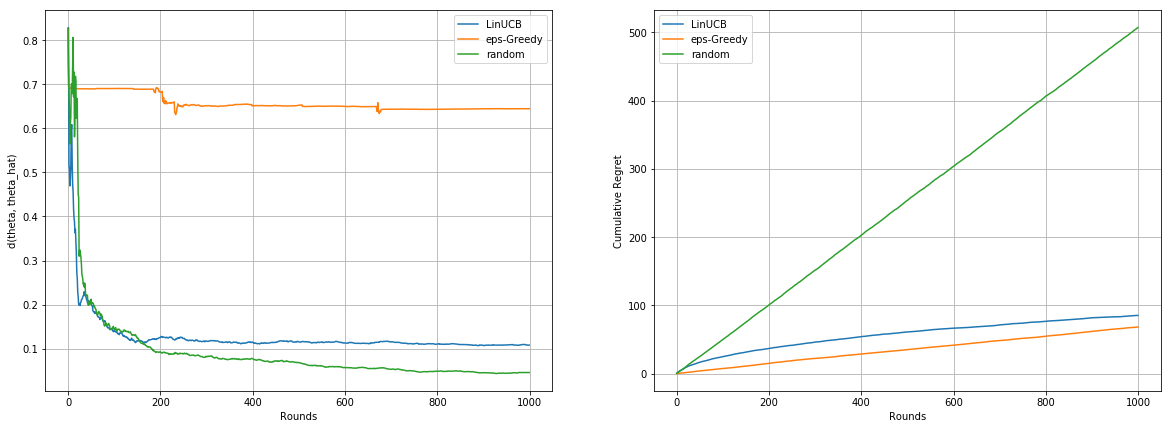

In [93]:
plt.figure(figsize=(20,7))
plt.subplot(121)
for i, a in enumerate(algorithms):
    plt.plot(mean_norms[i], label=a['name'])
plt.ylabel("d(theta, theta_hat)")
plt.xlabel('Rounds')
plt.legend()
plt.grid()


plt.subplot(122)
for i, a in enumerate(algorithms):
    plt.plot(mean_regret[i].cumsum(), label=a['name'])
plt.ylabel('Cumulative Regret')
plt.xlabel('Rounds')
plt.legend()
plt.grid()
plt.show()